# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [53]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [54]:
bikes_data =pd.read_csv('bikes_rent.csv') # put your code here
bikes_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

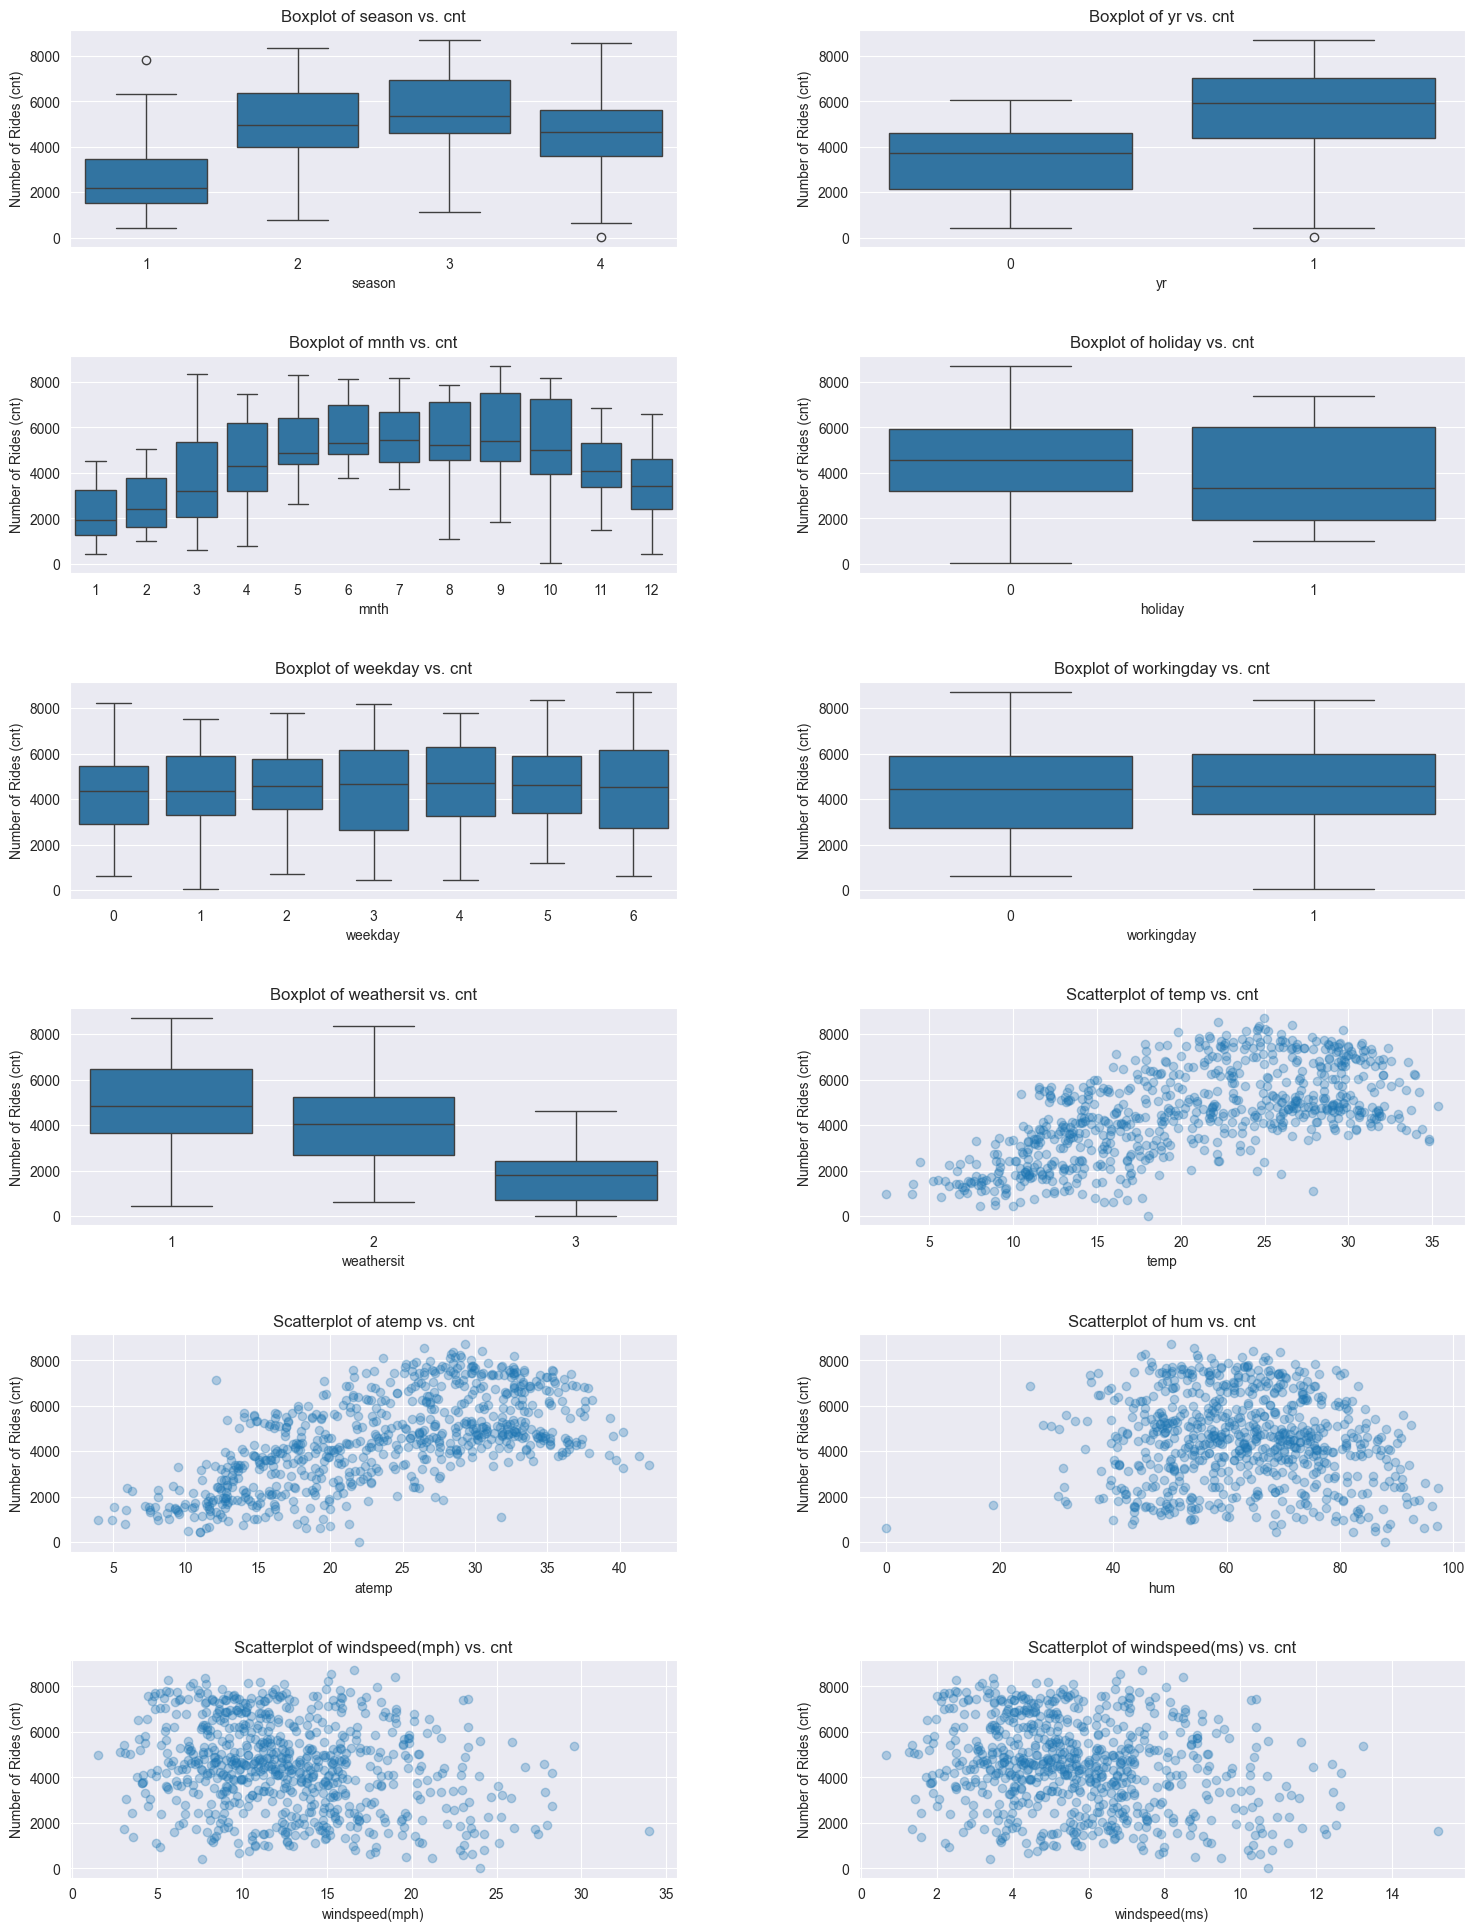

In [55]:
# Put you code here

fig, axs = plt.subplots(6, 2, figsize=(18, 24))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

boxplot_attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
scatterplot_attributes = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Plot boxplots
for idx, feature in enumerate(boxplot_attributes):
    sns.boxplot(ax=axs[idx//2, idx%2], x=bikes_data[feature], y=bikes_data['cnt'])
    axs[idx//2, idx%2].set_title(f'Boxplot of {feature} vs. cnt')
    axs[idx//2, idx%2].set_xlabel(feature)
    axs[idx//2, idx%2].set_ylabel('Number of Rides (cnt)')

# Plot scatterplots
for idx, feature in enumerate(scatterplot_attributes, start=len(boxplot_attributes)):
    axs[idx//2, idx%2].scatter(bikes_data[feature], bikes_data['cnt'], alpha=0.3)
    axs[idx//2, idx%2].set_title(f'Scatterplot of {feature} vs. cnt')
    axs[idx//2, idx%2].set_xlabel(feature)
    axs[idx//2, idx%2].set_ylabel('Number of Rides (cnt)')

plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?

1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.




__Відповідь__
1. Сезонний характер: Кількість прокатів має чітку сезонну залежність, з більшою активністю в теплі місяці і меншою активністю в холодні. Цей характер залежності є логічним і підтверджує, що погода є важливим фактором, який впливає на використання велосипедів.
2. Ознака 'temp' демонструє лінійну залежність на графіках розсіювання, де кількість прокатів зростає зі збільшенням температури.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [56]:
# Calculating the Pearson correlation coefficients among all features (excluding 'cnt') using the corr method
feature_correlations = bikes_data.iloc[:, :-1].corr()
feature_correlations 

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489


In [57]:
# Calculating the Pearson correlation coefficients between all features and the last feature 'cnt' using the corrwith method
correlations_with_cnt = bikes_data.corrwith(bikes_data['cnt'])
correlations_with_cnt 

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [58]:
# Calculating the Pearson correlation coefficients among continuous features including 'cnt' using the corr method
features = bikes_data[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]
pairwise_correlations  = features.corr()
pairwise_correlations 

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


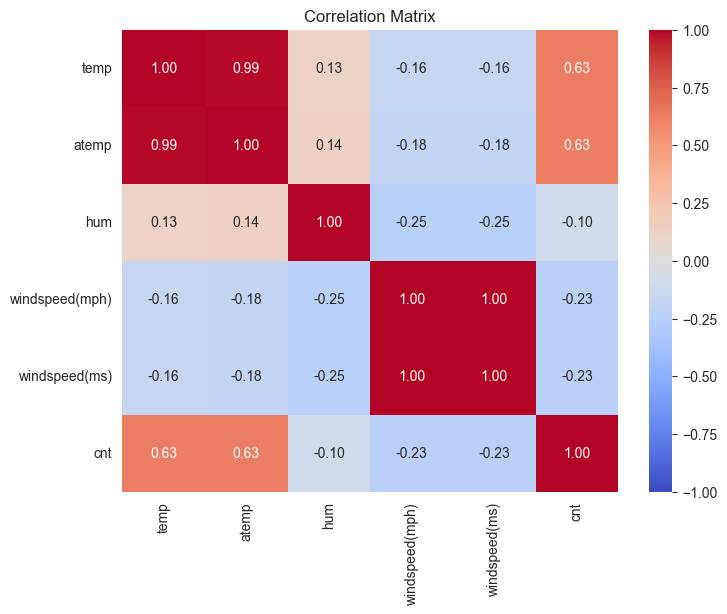

In [59]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pairwise_correlations, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [60]:
# Calculating the mean of each feature
feature_means = bikes_data.mean()
feature_means

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [61]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [62]:
bikes_data_shuffled = shuffle(bikes_data, random_state=42)
X = scale(bikes_data_shuffled[bikes_data_shuffled.columns[:-1]])
y = bikes_data_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [63]:
# from sklearn.linear_model import LinearRegression

# Scale the features
X_scaled = scale(X)

# Train a linear regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Get the feature weights
feature_weights = model.coef_

weights_bikes_data = pd.DataFrame({'Feature': bikes_data_shuffled.columns[:-1], 'Weight': feature_weights})
weights_bikes_data

,Feature,Weight
0,season,5.708651e+02
1,yr,1.021966e+03
2,mnth,-1.413024e+02
3,holiday,-8.675767e+01
4,weekday,1.372247e+02
5,workingday,5.639114e+01
6,weathersit,-3.302280e+02
7,temp,3.674851e+02
8,atemp,5.855458e+02
9,hum,-1.456127e+02


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [64]:
model = LinearRegression()

# Train the model on all data
X = bikes_data.iloc[:, :-1]  # Features (all columns except the last one)
y = bikes_data["cnt"]  # Target variable

model.fit(X, y)

feature_weights = model.coef_
feature_names = bikes_data.columns[:-1]

weights_bikes_data = pd.DataFrame({'Feature': feature_names, 'Weight': feature_weights})
weights_bikes_data

,Feature,Weight
0,season,5.142746e+02
1,yr,2.043935e+03
2,mnth,-4.096273e+01
3,holiday,-5.193787e+02
4,weekday,6.849516e+01
5,workingday,1.212932e+02
6,weathersit,-6.064508e+02
7,temp,4.899438e+01
8,atemp,7.191595e+01
9,hum,-1.023079e+01


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [65]:
from sklearn.linear_model import Lasso

# Shuffle the dataset
bikes_data_shuffled = shuffle(bikes_data, random_state=42)

# Separate features and target variable
X = bikes_data_shuffled.iloc[:, :-1]
y = bikes_data_shuffled["cnt"]

# Scale the features
X_scaled = scale(X)

# Create and train a Lasso regression model
lasso_model = Lasso()
lasso_model.fit(X_scaled, y)

# Get the feature weights
lasso_weights = lasso_model.coef_

lasso_weights_bikes_data = pd.DataFrame({'Feature': X.columns,'Weight': lasso_weights})
print(lasso_weights_bikes_data)

           Feature        Weight
0           season  5.602416e+02
1               yr  1.019463e+03
2             mnth -1.287306e+02
3          holiday -8.615278e+01
4          weekday  1.373479e+02
5       workingday  5.521237e+01
6       weathersit -3.323699e+02
7             temp  3.763632e+02
8            atemp  5.765308e+02
9              hum -1.441292e+02
10  windspeed(mph) -1.971397e+02
11   windspeed(ms) -2.805151e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [66]:
from sklearn.linear_model import Ridge

# Shuffle the dataset
bikes_data_shuffled = shuffle(bikes_data, random_state=42)

# Separate features and target variable
X = bikes_data_shuffled.iloc[:, :-1]
y = bikes_data_shuffled["cnt"]

# Scale the features
X_scaled = scale(X)

# Create and train a Ridge regression model
ridge_model = Ridge()
ridge_model.fit(X_scaled, y)

# Get the feature weights
ridge_weights = ridge_model.coef_

ridge_weights_bikes_data = pd.DataFrame({'Feature': X.columns,'Weight': ridge_weights})
print(ridge_weights_bikes_data)

           Feature       Weight
0           season   563.064572
1               yr  1018.948379
2             mnth  -131.873320
3          holiday   -86.746098
4          weekday   138.005111
5       workingday    55.903110
6       weathersit  -332.349788
7             temp   386.457889
8            atemp   566.347047
9              hum  -145.071327
10  windspeed(mph)   -99.259441
11   windspeed(ms)   -99.259441


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [67]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = [] 

for alpha in alphas:
    # Train Lasso model
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_scaled, y)
    coefs_lasso.append(lasso_model.coef_)
    
    # Train Ridge model
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_scaled, y)
    coefs_ridge.append(ridge_model.coef_)

# Convert the lists to np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

coefs_lasso, coefs_ridge

(array([[ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02,
         -8.61527813e+01,  1.37347894e+02,  5.52123706e+01,
         -3.32369857e+02,  3.76363236e+02,  5.76530794e+02,
         -1.44129155e+02, -1.97139689e+02, -2.80515127e-08],
        [ 4.10969632e+02,  9.77019409e+02, -0.00000000e+00,
         -5.34489688e+01,  9.19434374e+01,  1.75372118e+01,
         -3.18125568e+02,  3.22829934e+02,  6.10031512e+02,
         -9.10689615e+01, -1.45066095e+02, -2.29890301e-08],
        [ 3.70077089e+02,  9.35945490e+02,  0.00000000e+00,
         -1.21619360e+01,  4.88886342e+01,  0.00000000e+00,
         -3.08805664e+02,  2.69417263e+02,  6.32502623e+02,
         -2.75042876e+01, -9.37749037e+01, -2.41660929e-08],
        [ 3.32835717e+02,  8.91870058e+02,  0.00000000e+00,
         -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -2.79616688e+02,  2.11052030e+02,  6.62920880e+02,
         -0.00000000e+00, -5.01551472e+01, -2.62803010e-08],
        [ 2.98134448e+02,  8.4565285

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

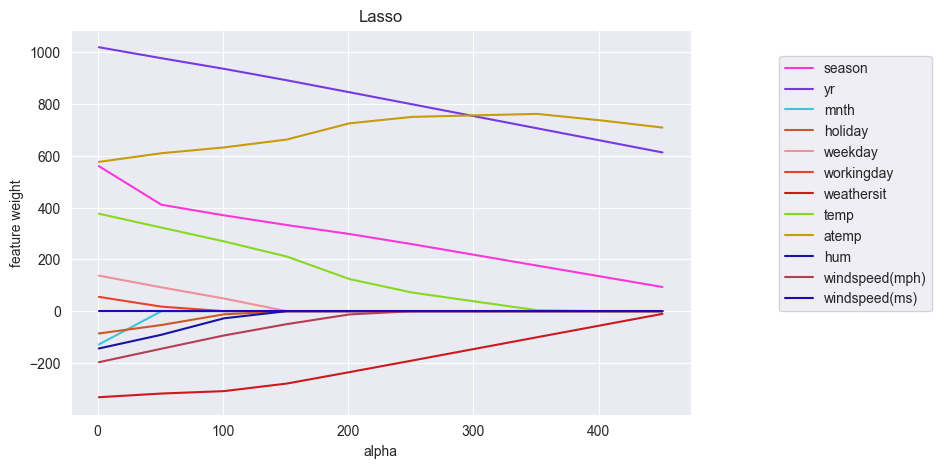

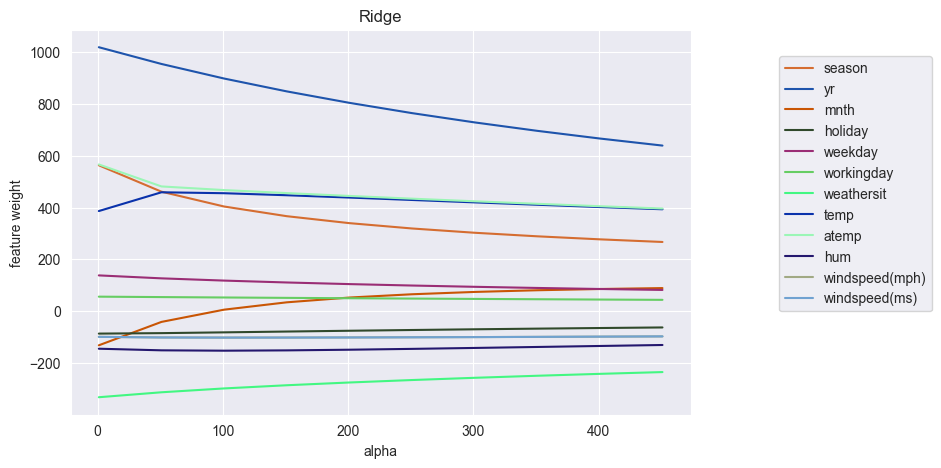

In [68]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, bikes_data.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, bikes_data.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?


1. Lasso агресивніше зменшує ваги при одному й тому самому значенні alfa. Це видно з того, що ваги ознак швидко зменшуються і стають нулями при збільшенні alfa. Ridge, з іншого боку, поступово зменшує ваги, але вони залишаються ненульовими.

2. Якщо alfa зробити дуже великим, всі ваги Lasso стануть нулями. Це відбувається тому, що L1-регуляризація додає до функціоналу втрат абсолютну суму ваг, змушуючи модель "штрафувати" за ненульові ваги. Зі збільшенням alfa цей штраф стає настільки великим, що оптимальним рішенням стає занулення всіх ваг.

3. Lasso дійсно виключає одну з ознак windspeed при будь-якому значенні alfa>0, оскільки одна з ваг windspeed стає нульовою або дуже близькою до нуля. Для Ridge цього не спостерігається - ваги windspeed зменшуються, але не стають нулями або дуже малими для будь-якого значення alfa.

4. Lasso краще підходить для відбору неінформативних ознак. Lasso має особливість встановлювати коефіцієнти незначущих ознак до нуля., тоді як Ridge лише зменшує їх вплив, але не зануляє.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [69]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [70]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)

regressor.fit(X_scaled, y)
best_alpha = regressor.alpha_

print(f"Alpha: {best_alpha}")

coef_weights = list(zip(bikes_data.columns[:-1], regressor.coef_))

for feature, weight in coef_weights:
    print(f"{feature}: {weight}")

Alpha: 6
season: 532.0189828413536
yr: 1015.0602226430597
mnth: -100.03952614356652
holiday: -83.2939598752991
weekday: 132.50446549095793
workingday: 51.557085614074055
weathersit: -330.5598567399815
temp: 370.67985503003166
atemp: 581.3969310655002
hum: -140.00740550068855
windspeed(mph): -191.7714084713498
windspeed(ms): -2.6855326892515688e-08


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas with minimum MSE:
Fold 1: Alpha = 6, MSE = 733725.760405224
Fold 2: Alpha = 1, MSE = 799433.1673691698
Fold 3: Alpha = 51, MSE = 796979.8955193625


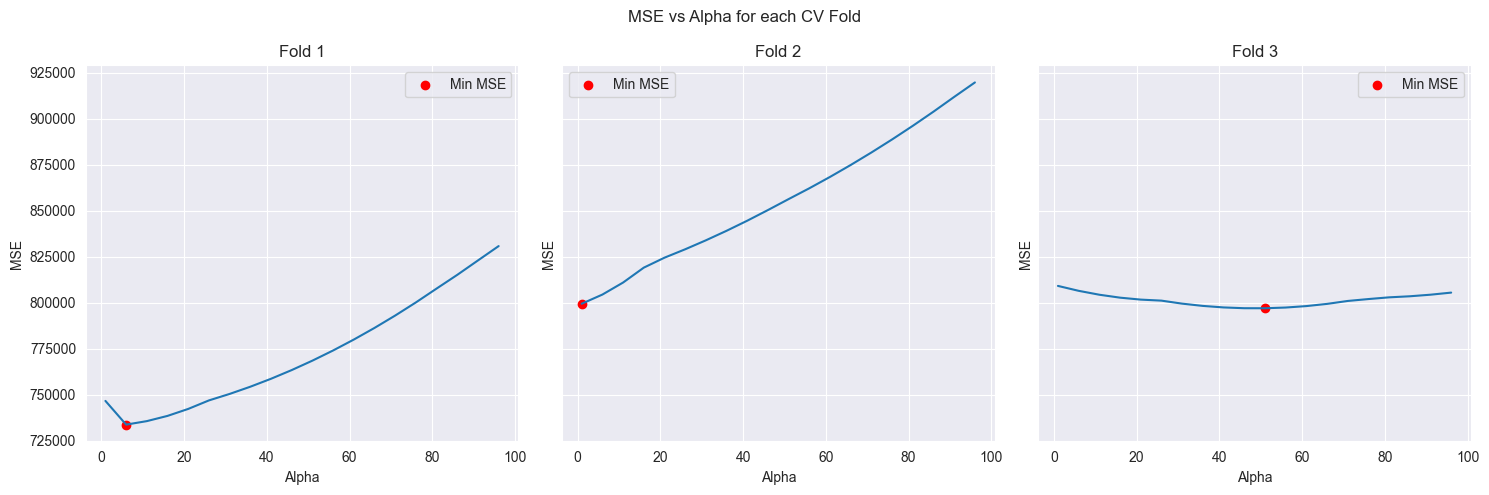

In [71]:
# Get the minimum MSE value for each fold
min_mse_values = np.min(regressor.mse_path_, axis=0)
min_mse_alphas = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]

# Print alpha values corresponding to minimum MSE on each fold
print("Alphas with minimum MSE:")
for fold, (alpha, mse) in enumerate(zip(min_mse_alphas, min_mse_values)):
    print(f"Fold {fold + 1}: Alpha = {alpha}, MSE = {mse}")
    
# Plot each column of mse_path_
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i in range(regressor.mse_path_.shape[1]):
    axs[i].plot(regressor.alphas_, regressor.mse_path_[:, i])
    axs[i].scatter(min_mse_alphas[i], min_mse_values[i], color='red', label='Min MSE')
    axs[i].set_title(f"Fold {i + 1}")
    axs[i].set_xlabel('Alpha')
    axs[i].set_ylabel('MSE')
    axs[i].legend()

plt.suptitle('MSE vs Alpha for each CV Fold')
plt.tight_layout()
plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

Чотири ознаки з найбільшими (позитивними) коефіцієнтами: 
yr: 1015.0602226430597
atemp: 581.3969310655002
season: 532.0189828413536
temp: 370.67985503003166 
На графіках, що показують залежність cnt від обраних ознак, ми можемо побачити наявність зростаючої лінійної залежності. Зокрема, якщо розглянути ознаки temp (температура) і atemp (відчутна температура), то зі збільшенням значень цих ознак спостерігається зростання кількості прокатів.Також можна помітити, що ознака yr (рік) також може мати певний позитивний вплив на кількість прокатів, що також має сенс, оскільки з плином часу може зростати популярність велопрокату або збільшуватися попит на цю послугу. Враховуючи аналіз залежності та здоровий глузд, можна логічно стверджувати, що чим більше значення ознак temp, atemp, season та yr, тим більша ймовірність, що більше людей братимуть велосипеди в оренду.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

Три ознаки з найбільшими за модулем негативними коефіцієнтами: weathersit: -330.5598567399815, windspeed(mph): -191.7714084713498, hum: -140.00740550068855. Для ознаки weathersit здається, що зі збільшенням значень погіршення погодних умов (високий індекс) кількість прокатів велосипедів зменшується.
Ознака windspeed(mph) показує, що зі збільшенням швидкості вітру кількість прокатів також зменшується. Ознака hum не показує чіткої лінійної залежності зі зменшенням кількості прокатів велосипедів, але може спостерігатися тенденція до зменшення при високих значеннях вологості.
Отже, на основі цих графіків можна логічно припустити, що чим більше значення ознак weathersit, windspeed(mph) та hum, тим менше людей захочуть взяти велосипеди напрокат.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

 Ознака з коефіцієнтами, близькими до нуля є windspeed(ms): -2.6855326892515688e-08. Основна причина, чому модель Lasso виключила цю ознаку, полягає у її взаємозамінності з windspeed(mph). На практиці, windspeed(ms) і windspeed(mph)  вимірюють ту саму характеристику (швидкість вітру), але в різних одиницях виміру. Отже оскільки одна з ознак вже ефективно використовується у моделі, друга може бути визначена як зайва і її вплив зведений до нуля. Якщо переглянути графіки залежності cnt від windspeed(mph) і windspeed(ms) то можна спостерігати, що зміни в windspeed(mph) добре корелюють з cnt, але аналогічні зміни в windspeed(ms) не показують виразної тенденції, а отже не додає додаткової інформаційної на попит на велосипеди.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.